In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
from particle_filter import particlefilter
from math_utils import nbinom_logpmf

In [2]:
'''Import data'''

data = pd.read_csv('..\\data_sets\\ou_data_nbinom.csv').to_numpy()
state = pd.read_csv('..\\data_sets\\ou_state_nbinom.csv').to_numpy()
betas = pd.read_csv('..\\data_sets\\ou_betas_nbinom.csv').to_numpy()

In [3]:
def SEIR_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,sig,mu,lam,_ = model_params

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_E = rng.poisson((particles[index,4,t] * (particles[index, 1, t] + 0.1 * particles[index, 2, t]) * particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_I = rng.poisson((1/7 * particles[index,1,t]) * dt)
        new_ER = rng.poisson((gamma * particles[index,1,t]) * dt)
        new_IR = rng.poisson((gamma * particles[index,2,t]) * dt)
        new_D = rng.poisson((0.004 * particles[index,2,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_E) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_E - new_I - new_ER) #E
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_I - new_IR - new_D) #I
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_ER + new_IR)
        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SEIR_Obs(data_point, particle_observations, model_params):
    r = 1/model_params[4]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0]),n = np.array([r]))
    weights[np.isinf(weights)] = -10_000
    return weights

In [4]:
'''True parameter values'''
rng = np.random.default_rng(0)

gamma = 1/14
R = 50
lam = 1/20
mean_ou = -1.1
sig = 0.5


T = 120
dt = 0.1
t_vec = np.arange(0,T,dt)

def SEIR_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    E_I_init = rng.integers(1,5,size = (num_particles * 2)).reshape((num_particles,2))
    particles_0[:,0] -= np.sum(E_I_init,axis = 1)
    particles_0[:,1] = E_I_init[:,0]
    particles_0[:,2] = E_I_init[:,1]
    particles_0[:,4] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':1_000, 
                      'dt':dt,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,sig,mean_ou,lam,1/R),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

8.310777900042012


 Log Likelihood : -10867.744096697154
Root Mean Squared Error for the Data 5026.65936199822
Root Mean Squared Error for beta 0.09870254730061122


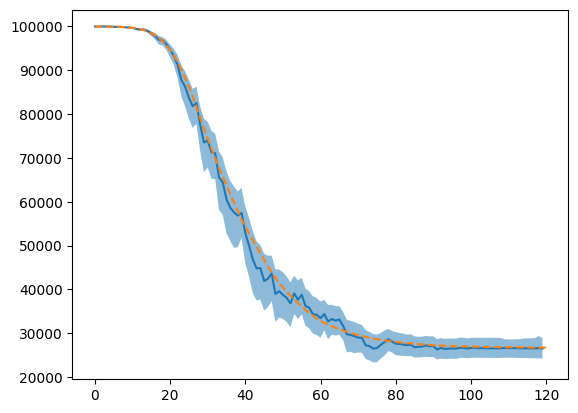

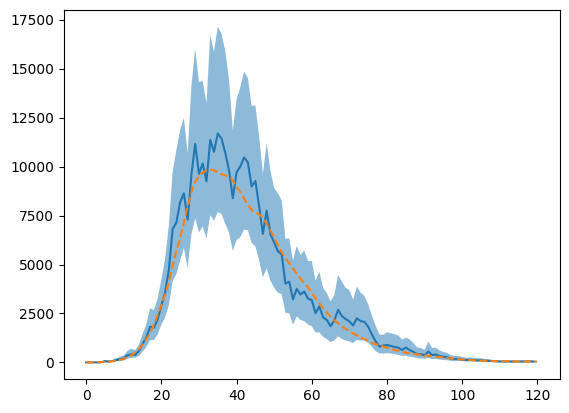

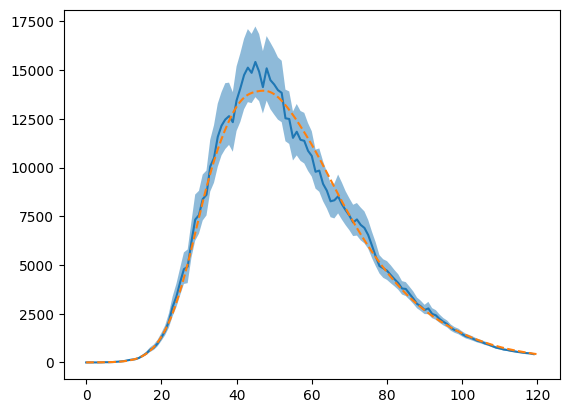

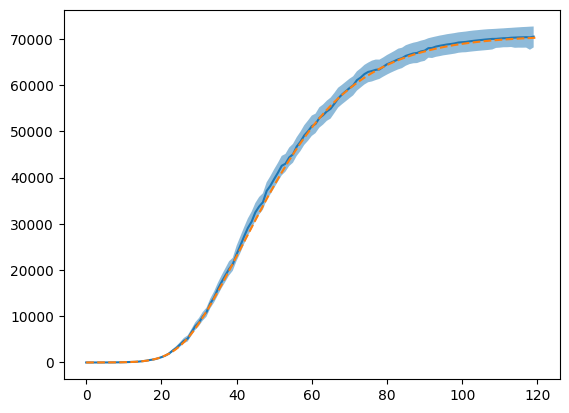

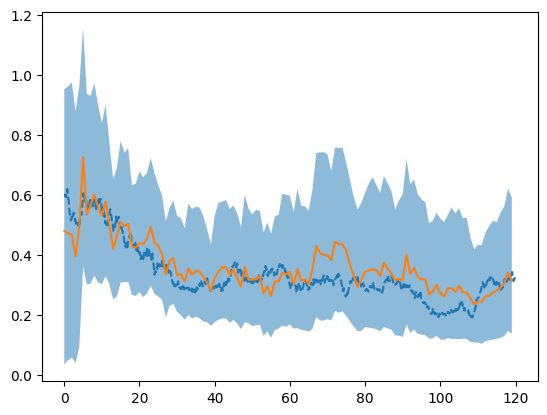

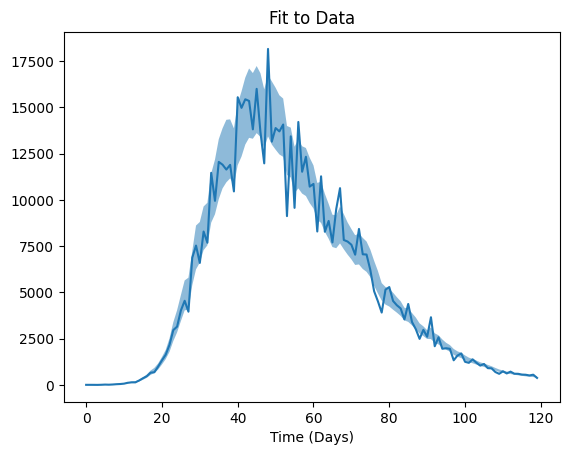

In [5]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")
print(f"Root Mean Squared Error for beta {np.sqrt(np.mean((betas - np.mean(output['particle_distribution'][:,4,:]))**2))}")

for i in range(4):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0))
    plt.plot(t_vec,state[i,:].T,'--')
    plt.show()

plt.plot(t_vec,betas,'--')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(output['particle_distribution'][:,4,:],weights = np.exp(output['log_weights']),axis = 0))
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()
